In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
tweets = pd.read_json('../input/iphone-11-tweets-fr.json', lines=True)
tweets.head(3)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/MiissShady76/status/133555...,2020-12-06 12:19:35+00:00,Qd ce n’est pas le PC qui plante ou qui n’a pl...,Qd ce n’est pas le PC qui plante ou qui n’a pl...,1335559509977280512,"{'username': 'MiissShady76', 'displayname': 'O...",[],[],0,0,...,0,1335559509977280512,fr,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,None,None
1,https://twitter.com/justinepercier/status/1335...,2020-12-06 12:19:06+00:00,Je suis passer d'un iPhone 11 a un iphone 7 et...,Je suis passer d'un iPhone 11 a un iphone 7 et...,1335559388086595587,"{'username': 'justinepercier', 'displayname': ...",[],[],0,0,...,0,1335559388086595587,fr,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,None,NaN,None,None
2,https://twitter.com/nami_2025/status/133555930...,2020-12-06 12:18:45+00:00,@anesosu Prend le samsung car iphone 11 pas no...,@anesosu Prend le samsung car iphone 11 pas no...,1335559300043984899,"{'username': 'nami_2025', 'displayname': 'SRS ...",[],[],0,0,...,0,1335558585003204609,fr,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,None,NaN,None,"[{'username': 'anesosu', 'displayname': 'Anes'..."


## 1. Exploration des données

Dans cette étape je vais explorer les tweets, on peut noter que notre source de données dispose plus de 100 mille tweets, ainsi chaque tweets et caractérisé par 21 colomnes.

In [3]:
tweets.shape

(109754, 21)

In [4]:
tweets.columns

Index(['url', 'date', 'content', 'renderedContent', 'id', 'user', 'outlinks',
       'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'media',
       'retweetedTweet', 'quotedTweet', 'mentionedUsers'],
      dtype='object')

Ce qui nous interesse le plus c'est la colomne `content` qui contien le contenu du tweet, donc on peux suprimer toute les autres colmnes, à noter que la colmne `renderedContent` est identique à la colomne `content`.

In [5]:
# pour etre sur que tout les tweets sont en français
tweets = tweets[tweets['lang'] == 'fr']
tweets['lang'].unique()

array(['fr'], dtype=object)

Avant de supprimer les colomnes inutiles, je vais vérifier l'évolution des tweets au fil du temps en utilisant la colomne `date`, et que chaque tweets est unique avec la colomne `id`.

In [6]:
# garder que la date et supprimer l'heure
tweets['date'] = pd.to_datetime(tweets['date']).dt.date

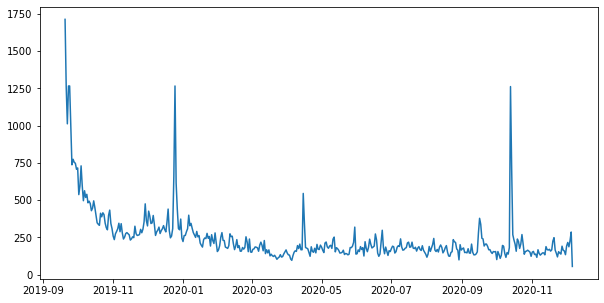

In [7]:
tweets['date'].value_counts().plot(kind='line', figsize=(10, 5))

plt.show()

On remarque que le nombre de tweets a atteint son maximum en septembre 2019, qui est le mois de la date de sortie de l'iPhone 11. Et le plus intéressant est qu'après un an, le nombre de tweets a encore augmenté en novembre 2020, qui est la date de sortie du nouvel iPhone 12, les gens comparaient peut-être les deux produits.

In [8]:
# vérifier qu'il y'a pas de redondance dans les tweets
tweets_cout = len(tweets)
unique_tweets = len(tweets['id'].unique())

tweets_cout, unique_tweets

(109753, 109753)

In [9]:
# supprimer les tweets dupliqués, 938 ont été supprimés
tweets = tweets.sort_values("content") 
  
# dropping ALL duplicte values 
tweets = tweets.drop_duplicates(subset ="content", keep = 'first')
tweets_cout - len(tweets)

938

Super! maintenant qu'on est sures que les tweets sont uniques on peut débarasser de toutes les colomnes apart la colomne `content` c'est la colomne sur laquelle je vais baser la suite du travail.

In [10]:
tweets = tweets['content']
tweets

22111    !! Ceux qui ont iphone 11!! \n Votre état de b...
2889     "\n            \n                Actualité : B...
95891    "\n            Actualité : Apple iPhone 11 : l...
99924    "\n            Actualité : Apple iPhone 11 : u...
92700    "\n            Actualité : Apple iPhone 11 Pro...
                               ...                        
41910    🦄 iPhone 11 et iPhone 11 Pro : prix, caractéri...
33137    🧓🏽Maman:mon fils ton nouveau téléphone est jol...
89523    🧥#MANTELSONNDEG🧥\nRemplissez les poches de vot...
28752    🧦Les dessous de cette campagne @Apple filmée à...
28474    🧦Les dessous de cette campagne @Apple filmée à...
Name: content, Length: 108815, dtype: object

## 2. Pré-traitement des tweets
Maintenant, après avoir préparé les tweets, nous pouvons commencer la phase de prétraitement afin de pouvoir nettoyer les tweets spécifiquement pour la phase d'identification du sujet. 
Pour des raisons de computation, je ne ferai des expériences que sur une partie des données `(25%)` afin de gagner du temps. Une fois que nous aurons validé le pipeline de prétraitement, je l'appliquerai à l'ensemble des données originales.

In [143]:
# selectionner aléatoirement 20% des tweets

data = tweets.sample(frac=0.2)
len(data)

21763

In [144]:
ads_words = [
    'concours', 'jeuconcours', 'giveaway',
    '#gagne' ,'#gangner', 'promo', 'promotion', 'publicité',
    'contest', '#ad', '#pub', '#réduction']

data = data[~data.str.contains('|'.join(ads_words), case=False)]

### 2.1 Importer les packages
Les paquets de base utilisés dans ce tutoriel sont `re`, `gensim`, `spacy` et `pyLDAvis`. En outre, nous utiliserons également `matplotlib`, `numpy` et `pandas` pour le traitement et la visualisation des données qui sont déja importés. 

pour le model du spacy dédié à la langue française, exectutez cette commande sur votre terminal conda:  
`!python -m spacy download fr_core_news_sm`  

pour importer le model: `spacy.load('fr_core_news_sm')`

In [122]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [123]:
# fonction pour supprimer les symbols HTML

from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [124]:
# remplacement des abréviations
import json

with open('../input/abrivot_fr.json', encoding='utf-8') as f:
    abrivot = json.load(f)
    
dict(list(abrivot.items())[0:5])

{'@tt': 'à tout à l’heure',
 '@tte': 'à tout à l’heure',
 'a tte': 'à tout à l’heure',
 'a12c4': 'à un de ces quatre',
 'a2m1': 'à demain'}

In [125]:
# pour supprimer les emojis
# ce package est capable de remplacer les emojis avec leur signification en text BEAST!!!
import demoji
#demoji.download_codes()

In [132]:
# lemmatization
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

def lemmatization(text):
    doc = nlp(text) 
    text_out = ' '.join([token.lemma_ for token in doc])
    return text_out

In [133]:
import re
from gensim.utils import simple_preprocess

def tweets_formatting(tweets):
    all_tweets=[]
    for tweet in tweets:
        # mettre le texte en miniscule
        lower_case = tweet.lower()
        
        # remplacer les abréviations
        words = lower_case.split()
        reformed = [abrivot[word] if word in abrivot else word for word in words]
        reformed = " ".join(reformed) 
        
        # supprimer les caractères de saut de ligne
        reformed = ' '.join([re.sub('\s+', ' ', sent) for sent in reformed.split()])
        
        # supprimer les symboles HTML
        reformed = strip_tags(reformed)
        
        # supprimer les urls et les @mentions
        reformed = re.sub(r'(?:\@|https?\://)\S+', '', reformed)
        
        # spprimer les émoticons et les émojis
        reformed = demoji.replace(reformed, '')
        
        # suppression des punctuations et les chiffres
        reformed = ' '.join(simple_preprocess(str(reformed), deacc=True))
        
        # lemmatization
        reformed = lemmatization(reformed)
        
        all_tweets.append(reformed)
    all_text = ' '.join(all_tweets)
    all_words = all_text.split()
    return all_tweets, all_words

In [146]:
all_tweets, all_words = tweets_formatting(data)
all_tweets[:1]

['oui achete moi iphone pro il te pler']

In [147]:
# préparer la liste des mots vide
import nltk
#nltk.download('stopwords')

In [171]:
# importer les mots vides de la langue Française
stop_words = set()
stop_words.update(tuple(nltk.corpus.stopwords.words('french')))

In [172]:
# mettre à jour la liste d'après notre fichier des mots vides, 75 mots ont été rajoutés
old_stopwords_len = len(stop_words)

with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    words = f.read().splitlines()
stop_words.update(words)

len(stop_words) - old_stopwords_len

75

In [173]:
#selectionner les mots les plus pertinants

from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
sorted_words[:10]

[('le', 16156),
 ('iphone', 14672),
 ('de', 12838),
 ('un', 11792),
 ('iphon', 10026),
 ('être', 9421),
 ('pro', 7272),
 ('avoir', 6808),
 ('je', 6520),
 ('et', 5825)]

In [174]:
# mettre à jour la liste des mots vides avec les 30 mots les plus fréquents
old_stopwords_len = len(stop_words)

top_words = [word[0] for word in sorted_words[:30]]
stop_words.update(top_words)

len(stop_words) - old_stopwords_len

8

In [191]:
def remove_stopwords(texts):
    return [[word for word in doc.split() if word not in stop_words] for doc in texts]

tokens = remove_stopwords(all_tweets)
tokens[:2]

[['oui', 'achete', 'pler'],
 ['boite', 'lettre', 'commande', 'ete', 'faite', 'hier', 'portable', 'enfin']]

In [195]:
all_tweets = [' '.join(doc) for doc in tokens if len(doc) > 1]
all_words = (' '.join(all_tweets)).split()

La suppression des documents non valables (données bruits). Par exemple les publicités, les tweets qui n'ont pas de relation avec le produit.  

Les documents relatifs au bruit sont définis comme ceux qui ne comportent aucun mot-clé lié au produit (iphone 11).

In [196]:
from gensim.summarization import keywords
print(keywords(' '.join(all_words)))

achet
achetent utilisent
photos
prendr
voire
telephone
telephoner
telephones
telephon
qualites
qualiter
offrir
offrire
petit
petition
coque
coqu
coques
pay cash acheter limite
venir
meme ancien puis nouveau
ecrans
apres
contre
command
moy
gen
etr
jours
toujour
vendr
a_vendre
coupe
meilleurer
meilleurs
demand
demandent
dejer
merci garcon qualit
gro
oui achete pler boite lettre commande ete faite hier portable enfin
rentree mars arriver dire
putain
airpods
niveau jamais voir amazon
quelque
quelques
payer
franc batteri
surement non
mond
croire
croir
batterie objectif photo truc bizarre jusqu celui utilise toujours appareil
vue quoi
entr
bien raison appl fabrique haut gamme inde
recu prendre vert serieux beau mieux violet avai plan prix
etes
tre
certain personne passer vie
commander super
test
teste
tests
premiere
premieres
premierement
arriv
arrivent
utiliser
utilisable
mem tweet anniversaire mois
genre
genr
semainer
savoir completement moyen mort rire
deja
comparer videos
argent
mere
jam